```
[Start] 
  ↓
DatePlannerAgent
  ↓
CityPlannerAgent
  ↓
FlightSearchAgent
  ↓
[End]
```

In [1]:
from dotenv import load_dotenv

# .env 파일의 환경변수를 기존 값과 상관없이 덮어쓰기
load_dotenv(override=True)

True

In [2]:
from tools.debugs import check_langsmith_env

check_langsmith_env()

🦜Tracing 'Travel_Agent' by LangSmith


In [2]:
from langchain.chat_models import ChatOpenAI
import os


llm = ChatOpenAI(
    # model_name="deepseek/deepseek-chat:free",
    model_name="meta-llama/llama-3.3-70b-instruct:free",
    temperature=0,
    openai_api_base="https://openrouter.ai/api/v1",
    openai_api_key=os.getenv("OPENROUTER_API_KEY")
)

/var/folders/j1/rm0gdwk50j339fwgq9nr34t40000gn/T/ipykernel_66849/176521888.py:5: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(


In [3]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Optional, List

# 상태 정의
class TravelState(TypedDict):
    start_date: Optional[str]
    end_date: Optional[str]
    destination_city: Optional[str]
    flight_options: Optional[List[str]]

# 날짜 묻는 노드
def ask_dates(state: TravelState) -> TravelState:
    print("📅 여행 시작일과 종료일을 입력해 주세요. (예: 2025-04-10 ~ 2025-04-12)")
    response = input("→ 입력: ")

    try:
        # 간단한 파싱 (실제 파서랑 연결하면 더 좋아)
        start, end = response.split("~")
        state["start_date"] = start.strip()
        state["end_date"] = end.strip()
    except Exception as e:
        print("⚠️ 날짜 형식을 인식할 수 없어요! 기본값을 사용할게요.")
        state["start_date"] = "2025-04-10"
        state["end_date"] = "2025-04-12"

    return state

# 도시 묻는 노드
def ask_city(state: TravelState) -> TravelState:
    print("📍 여행할 도시를 입력해 주세요.")
    city = input("→ 입력: ")
    state["destination_city"] = city.strip()
    return state

# 항공편 찾는 노드
def search_flights(state: TravelState) -> TravelState:
    print(f"\n✈️ 항공편 검색 중...")
    print(f"   날짜: {state['start_date']} ~ {state['end_date']}")
    print(f"   도시: {state['destination_city']}\n")

    state["flight_options"] = [
        f"{state['start_date']} 출발 ✈️ Flight A",
        f"{state['end_date']} 귀국 ✈️ Flight B"
    ]
    return state


# ✅ LangGraph 구성 (질문 처리를 위한 구조 추가!)
graph = StateGraph(TravelState)
graph.add_node("ask_dates", ask_dates)
graph.add_node("ask_city", ask_city)
graph.add_node("search_flights", search_flights)

# ✅ 흐름 구성 (질문을 중간에 처리)
graph.set_entry_point("ask_dates")
graph.add_edge("ask_dates", "ask_city")  # 질문 먼저 체크
graph.add_edge("ask_city", "search_flights")   # 또 질문 체크
graph.add_edge("search_flights", END)  # 답변 -> 종료


travel_graph = graph.compile()

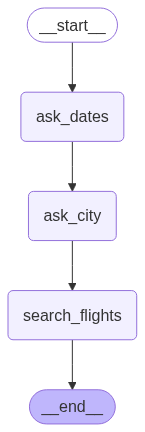

In [5]:
from IPython.display import Image, display
# Mermaid 시각화
try:
    display(Image(travel_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print("그래프 시각화 실패:", e)
    print(travel_graph.get_graph().draw_mermaid())  # 소스코드 출력

In [6]:
initial_state = {
    "start_date": None,
    "end_date": None,
    "destination_city": None,
    "flight_options": None,
    "user_query": None,
}

result = travel_graph.invoke(initial_state)

print("\n🧳 최종 여행 계획:")
print(f"  날짜: {result['start_date']} ~ {result['end_date']}")
print(f"  도시: {result['destination_city']}")
print(f"  항공편:")
for option in result["flight_options"]:
    print(f"   - {option}")


📅 여행 시작일과 종료일을 입력해 주세요. (예: 2025-04-10 ~ 2025-04-12)
📍 여행할 도시를 입력해 주세요.

✈️ 항공편 검색 중...
   날짜: 2025-06-25 ~ 2025-06-27
   도시: paris


🧳 최종 여행 계획:
  날짜: 2025-06-25 ~ 2025-06-27
  도시: paris
  항공편:
   - 2025-06-25 출발 ✈️ Flight A
   - 2025-06-27 귀국 ✈️ Flight B
